In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
import importlib
import math
import os
from collections import defaultdict
import torch
from torch.utils.data import Dataset
from k_means_constrained import KMeansConstrained
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import subprocess
import sys
%matplotlib inline
import GnnScheduleDataset as GnnScheduleDataset_Module
import MultiCriteriaGNNModel as MultiCriteriaGNNModel_Module
import ScheduleEvaluator as ScheduleEvaluator_Module

importlib.reload(GnnScheduleDataset_Module) # in case of updates
importlib.reload(MultiCriteriaGNNModel_Module) # in case of updates
importlib.reload(ScheduleEvaluator_Module) # in case of updates

from GnnScheduleDataset import GnnScheduleDataset
from MultiCriteriaGNNModel import MultiCriteriaGNNModel
from ScheduleEvaluator import ScheduleEvaluator

#manual installing
def install_package(package_name, use_index_url=True):
    print(f"Installing {package_name}...")
    #run: python.exe -m pip install [package_name]

    subprocess.run(
        [sys.executable, "-m", "pip", "uninstall", "-y", package_name],
        check=True,
        text=True
    )
    if use_index_url:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", package_name, "--index-url", "https://download.pytorch.org/whl/cu126"],
            check=True,
            text=True
        )
    else:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", package_name],
            check=True,
            text=True
        )
    print(f"Successfully installed {package_name}!")

# Try to import, if it fails, install it
# try:
#     import torch
#     print("Torch is already available.")
# except: 
#     #install_package('torch')
#     # After installing, you must use importlib to refresh or restart the script
#     import torch
#     print("Torch imported successfully after installation.")

#torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
#torch-scatter torch-sparse torch-cluster torch-spline-conv
# install_package('torch-scatter')
# install_package('torch-sparse')
# install_package('torch-cluster')
# install_package('torch-spline-conv')

# try:
#     import torch_geometric
#     print("Torch is already available.")
# except: 
#     install_package('torch_geometric', False)
#     # After installing, you must use importlib to refresh or restart the script
#     import torch_geometric
#     print("Torch imported successfully after installation.")

#Try to import, if it fails, install it
# try:
#     import k_means_constrained
#     print("k_means_constrained is already available.")
# except: 
#     install_package('k_means_constrained', False)
#     # After installing, you must use importlib to refresh or restart the script
#     import torch
#     print("k_means_constrained imported successfully after installation.")

#file paths
TARGET_MINI_BATCH_SIZE = 10 #number of missions per mini-batch
LARGE_SCALE_MISSION_BATCH_DIR = "./datasets/Batch1000M.csv"
PREPROCESSED_BATCH_DIR = f"./preprocessed/batch1000M/Batch{TARGET_MINI_BATCH_SIZE}M_idx.xlsx" #idx to be replaced cluster idx
MISSION_BATCH_DIR = "./datasets/mini-batch/Batch10M_distanced.csv"
UDC_TYPES_DIR = "./datasets/WM_UDC_TYPE.csv"
MISSION_BATCH_TRAVEL_DIR = "./datasets/mini-batch/Batch10M_travel_distanced.csv"
FORK_LIFTS_DIR = "./datasets/ForkLifts10W.csv"
#MISSION_TYPES_DIR = "./datasets/MissionTypes.csv"
SCHEDULE_DIR = "./schedules/mini-batch/"
NUM_EPOCHS = 10
BATCH_SIZE = 1 #86 #nice to be equal to the number of mini-batch instances
LEARNING_RATE = 0.001


c:\Users\abudo\source\vscode_projects\ManualWarehouseOptimization\cplex_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing
Split the large-scale batch in mini-batches (ex. 10 missions each) using spatial k-means, considering only `FROM_X, FROM_Y, FROM_Z, TO_X, TO_Y, TO_Z`.

In [3]:
def create_spatial_batches_and_save(input_csv=LARGE_SCALE_MISSION_BATCH_DIR, target_batch_size=TARGET_MINI_BATCH_SIZE):
    """
    groups missions into spatially dense clusters of <50 missions 
    and saves each group to a separate CSV file.
    """
    os.makedirs(os.path.dirname(PREPROCESSED_BATCH_DIR), exist_ok=True)
    
    #load the main dataset
    df = pd.read_csv(input_csv).drop_duplicates(subset=['CD_MISSION'], keep='first')
    df = df.reset_index(drop=True)
    n_samples = len(df)
    
    #determine number of clusters
    n_clusters = max(1, math.ceil(n_samples / target_batch_size))
    print(f"total orders: {n_samples} | target clusters: {n_clusters}")

    if n_clusters == 1:
        df['cluster_id'] = 0
        df.to_csv('cluster_0.csv', index=False)
        return ["cluster_0.csv"]

    #feature Selection: 6D spatial coordinates
    #use both pickup (from) and drop-off (to) locations
    coord_cols = ['FROM_X', 'FROM_Y', 'FROM_Z', 'TO_X', 'TO_Y', 'TO_Z']
    
    for col in coord_cols:
        if df[col].dtype == 'object' or df[col].dtype == 'string':  #only apply to string/object columns
            df[col] = df[col].str.replace(',', '', regex=False)

    coords = df[coord_cols].astype(float).fillna(0).values
    
    #standardize (crucial for K-Means distance calculations)
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)
    
    #cluster logic
    if n_clusters > 1:
        #kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) #produces some very unbalanced clusters
        #df['cluster_id'] = kmeans.fit_predict(coords_scaled)

        clf = KMeansConstrained(
            n_clusters=n_clusters,
            size_min=target_batch_size - 1,
            size_max=target_batch_size + 1,
            random_state=42
        )
        df['cluster_id'] = clf.fit_predict(coords_scaled)

        # model = BisectingKMeans(n_clusters=n_clusters, random_state=42, bisecting_strategy='largest_cluster')
        # df['cluster_id'] = model.fit_predict(coords_scaled)
    else:
        df['cluster_id'] = 0
    
    #save each cluster to its own file with original coordinates
    saved_files = []
    for cid in sorted(df['cluster_id'].unique()):
        cluster_df = df[df['cluster_id'] == cid].copy()
        
        #remove the temporary cluster_id before saving if desired
        cluster_df = cluster_df.drop(columns=['cluster_id'])
        
        file_name = PREPROCESSED_BATCH_DIR.replace("idx", str(cid+1))
        if file_name.endswith('.csv'):
            cluster_df.to_csv(file_name, index=False)
        else:
            cluster_df.to_excel(file_name, index=False)
            
        saved_files.append(file_name)

        print(f"saved {file_name} with {len(cluster_df)} missions.")
    
    return saved_files

#create_spatial_batches_and_save()

### Loss Defination
The loss function is a Weighted Sum of Binary Cross-Entropy (BCE) Losses. We choose BCE since the MIP model provides a binary solution "Yes/No" for every decision (Operator A was used, Edge X was traversed), so its treated as a supervised binary classification problem at every decision point.


It combines three distinct error signals, each corresponding to one of the decision heads (Activation, Assignment, Sequence), and weighted by the problem parameters alpha and beta to reflect the business priorities.

$$L_{\text{total}} =  \alpha \cdot (L_{\text{assignment}} + L_{\text{sequence}}) + \beta \cdot L_{\text{activation}}$$

Loss components:

* Activation Loss ($\mathcal{L}_{activation}$):
    BCELoss between predicted probabilities $P(active)$ and ground truth labels (0 or 1), in order to learn which operators to turn on.

    Its weight is scaled by $\beta$ (the penalty for using an extra operator). If $\beta$ is high, the model is penalized heavily for activating unnecessary forklifts.

* Assignment Loss ($\mathcal{L}_{assignment}$):
    BCELoss between predicted $P(assign)$ and ground truth edges (1 if Op $i$ did Order $j$, else 0), in order to learn orders assignement.

    Its weight is scaled by $\alpha$ (proxy for makespan/efficiency).

* Sequence Loss ($\mathcal{L}_{sequence}$):
    BCELoss between predicted $P(sequence)$ and ground truth transitions (1 if Order $j$ immediately follows Order $i$), In order to learn the sequencing of tasks.

    Its weight is also scaled by $\alpha$, as better sequencing directly reduces travel time.

Since we have considered a weighted loss function, the backward step propagated the participant heads w.r.t. their weight in the weighted loss. Nevertheless, the gradient conflict is a real issue, in which a head might require an optimization step on the opposite direction of the overwhelming optimization direction:

If $\nabla L_{\text{act}}$ and $\nabla L_{\text{assign}}$ point in opposite directions on shared weights $\theta_{\text{shared}}$, the update rule:
$$\theta_{\text{shared}} \leftarrow \theta_{\text{shared}} - \eta \left( \beta \nabla_{\theta} L_{\text{act}} + \alpha \nabla_{\theta} L_{\text{assign}} \right)$$

can result in partial cancellation if:
$$\cos(\phi) = \frac{\nabla L_{\text{act}} \cdot \nabla L_{\text{assign}}}{\|\nabla L_{\text{act}}\| \|\nabla L_{\text{assign}}\|} < 0$$


To have more control on the loss effectiveness over heads, we'd adopt a **separate optimizer for each head**, while the global loss weight ($\alpha, \beta$) scales the gradient magnitude passed to the shared trunk. Separate optimizers allow us to scale the update step size (learning rate) for each head independently. This is particularly useful if one task (e.g., Sequencing) is much harder to learn or requires a different convergence speed than another (e.g., Activation). We need to have a seperation strategy as the following:  
1. Parameters partitioning: Split the model into the shared "trunk" (GNN layers) and the individual "heads" (MLP layers).
2. Separate optimizers initialization: Assign different learning rates (LR) or even different algorithms (Adam vs SGD) to each optimizer based on the observed learning curve per head/task.
3. Single training loop: All optimizers should work on the same number of epochs in the training loop. So the backward pass remains largely the same (a single global graph), but the updates are decoupled. A backward step could be freezed (by not calling it) per any optimizer in case of necessity.

Real examples of our GNN heads separated optimizers:  
* Fast learning: If **activation** is easy and learns instantly, its large gradients might distort the GNN embeddings early on. We can set the relative **learning rate** to be very low (or 0) for the first few epochs ("Warm-up").
* Lazy learning:  If **Sequence** loss is small (due to low $\alpha$) but we want the head to learn faster, we can increase the relative **learning rate**. This will boost the head's adaptation without forcing us to increase $\alpha$ (which would destabilize the trunk).

### Loss Plot

In [4]:
'''
model_evaluation should contain loss, val_loss, accuracy, accuracy_icat
'''
def performance_plot(model_evaluation:dict, ignore_accuracy_plot=False):
    plt.figure(figsize=(16, 6))

    if not ignore_accuracy_plot:
        plt.subplot(1, 2, 1)

    #plot loss
    plt.plot(model_evaluation['train_loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot accuracy score
    if not ignore_accuracy_plot:
        plt.subplot(1, 2, 2)
        plt.plot(model_evaluation['train_accuracy'])
        plt.plot(model_evaluation['val_accuracy'])
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['training', 'validation'])

    plt.show()

Using device: cuda
found 92 valid schedule instances.
Using device: cuda
First element of the schedule training set: HeteroData(
  u=[1, 3],
  order={
    x=[10, 10],
    global_id=[10],
  },
  operator={
    x=[10, 7],
    global_id=[10],
    y=[10],
  },
  (order, to, order)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
    y=[90],
  },
  (operator, assign, order)={
    edge_index=[2, 100],
    edge_attr=[100, 1],
    y=[100],
  },
  (order, rev_assign, operator)={
    edge_index=[2, 100],
    edge_attr=[100, 1],
  }
)
First element of the schedule test set: HeteroData(
  u=[1, 3],
  order={
    x=[9, 10],
    global_id=[9],
  },
  operator={
    x=[10, 7],
    global_id=[10],
    y=[10],
  },
  (order, to, order)={
    edge_index=[2, 72],
    edge_attr=[72, 1],
    y=[72],
  },
  (operator, assign, order)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
    y=[90],
  },
  (order, rev_assign, operator)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
  }
)


epoch 1/10: 100%|██████████| 78/78 [00:03<00:00, 20.05it/s]


(act_loss: 0.626, assign_loss: 0.146, seq_loss: 0.424)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 28.12it/s]


[Epoch 1]: Training Loss: 63.1573600769043, Validation Loss: 64.88109915597099


epoch 2/10: 100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


(act_loss: 0.511, assign_loss: 0.131, seq_loss: 0.365)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 29.51it/s]


[Epoch 2]: Training Loss: 51.62748336791992, Validation Loss: 53.00399317060198


epoch 3/10: 100%|██████████| 78/78 [00:03<00:00, 20.79it/s]


(act_loss: 0.365, assign_loss: 0.104, seq_loss: 0.535)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 27.12it/s]


[Epoch 3]: Training Loss: 37.1417236328125, Validation Loss: 52.96245193481445


epoch 4/10: 100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


(act_loss: 0.500, assign_loss: 0.130, seq_loss: 0.368)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 30.19it/s]


[Epoch 4]: Training Loss: 50.540809631347656, Validation Loss: 54.21864209856306


epoch 5/10: 100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


(act_loss: 0.327, assign_loss: 0.067, seq_loss: 0.493)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 28.85it/s]


[Epoch 5]: Training Loss: 33.307132720947266, Validation Loss: 52.991054262433735


epoch 6/10: 100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


(act_loss: 0.672, assign_loss: 0.199, seq_loss: 0.335)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 29.61it/s]


[Epoch 6]: Training Loss: 67.74161529541016, Validation Loss: 53.81806509835379


epoch 7/10: 100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


(act_loss: 0.699, assign_loss: 0.215, seq_loss: 0.215)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 28.72it/s]


[Epoch 7]: Training Loss: 70.35189819335938, Validation Loss: 56.971230915614534


epoch 8/10: 100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


(act_loss: 0.673, assign_loss: 0.219, seq_loss: 0.259)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 29.67it/s]


[Epoch 8]: Training Loss: 67.78033447265625, Validation Loss: 52.9899719783238


epoch 9/10: 100%|██████████| 78/78 [00:03<00:00, 21.95it/s]


(act_loss: 0.501, assign_loss: 0.107, seq_loss: 0.330)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 27.88it/s]


[Epoch 9]: Training Loss: 50.58222198486328, Validation Loss: 53.02236720493862


epoch 10/10: 100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


(act_loss: 0.505, assign_loss: 0.130, seq_loss: 0.365)


Evaluating on test set: 100%|██████████| 14/14 [00:00<00:00, 29.10it/s]


[Epoch 10]: Training Loss: 50.94667053222656, Validation Loss: 53.96761294773647


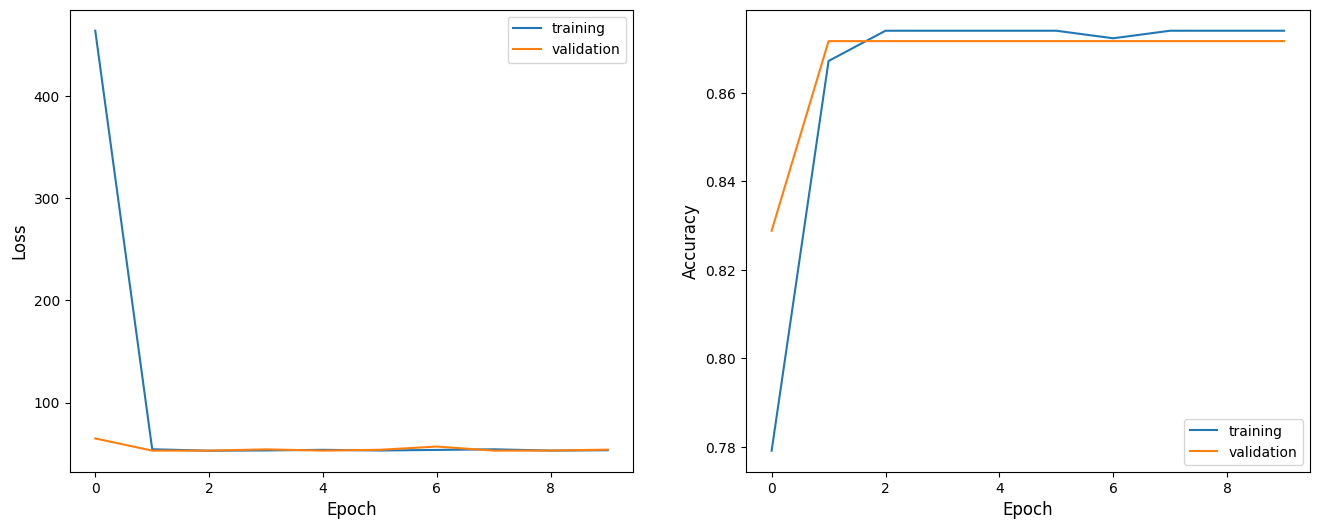

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#init dataset
dataset = GnnScheduleDataset(
    schedule_dir=SCHEDULE_DIR,
    mission_base_path=MISSION_BATCH_DIR,
    edge_base_path=MISSION_BATCH_TRAVEL_DIR,
    pallet_types_file_path=UDC_TYPES_DIR,
    fork_path=FORK_LIFTS_DIR
)

print(f"found {len(dataset)} valid schedule instances.")

#init model
if len(dataset) > 0:
    sample_data = dataset[0]
    model = MultiCriteriaGNNModel(
        metadata=sample_data.metadata(),
        hidden_dim=64,
        num_layers=3,
        heads=4
    ).to(device)

    schedule_evaluator = ScheduleEvaluator(model=model, 
                                           schedule_dataset=dataset, 
                                           batch_size=BATCH_SIZE)

    #create dataLoader using the training dataset
    #batch_size can be > 1 to train on multiple graphs at once
    loader = DataLoader(schedule_evaluator.schedule_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    #adam optimizer is a standard for GNNs
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    perfermace_records = defaultdict(list)
    
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_epoch_loss = 0.0
        total_epoch_accuracy = 0.0

        for batch_idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f"epoch {epoch}/{NUM_EPOCHS}"):
            batch = batch.to(device)
            optimizer.zero_grad()
            
            #construct batch_dict
            batch_dict_arg = {
                'operator': batch['operator'].batch,
                'order': batch['order'].batch
            }
            
            #forward pass
            preds = model(
                batch.x_dict, 
                batch.edge_index_dict, 
                batch.edge_attr_dict,
                batch.u,
                batch_dict=batch_dict_arg
            )
            
            #backward step and optimization
            loss, l_act, l_assign, l_seq = schedule_evaluator.weighted_loss(preds, batch, batch.u)
            measurements = schedule_evaluator.calculate_metrics(preds, batch)

            loss.backward()
            optimizer.step()
            
            total_epoch_loss += loss.item()
            total_epoch_accuracy += sum([measurements['act_acc'], measurements['assign_acc'], measurements['seq_acc']]) / 3.0
            
        avg_loss = total_epoch_loss / len(loader)
        avg_accuracy = total_epoch_accuracy / len(loader)
        
        #print(f"Epoch {epoch} complete. average loss: {avg_loss:.4f}")
        print(f"(act_loss: {l_act:.3f}, assign_loss: {l_assign:.3f}, seq_loss: {l_seq:.3f})")

        perfermace_records['train_loss'].append(avg_loss)
        perfermace_records['train_accuracy'].append(avg_accuracy)

        #validation step
        val_loss, val_accuracy, act_loss, assign_loss, seq_loss = schedule_evaluator.evaluate()

        print(f"[Epoch {epoch}]: Training Loss: {loss.item()}, Validation Loss: {val_loss}")
        
        perfermace_records['val_loss'].append(val_loss)
        perfermace_records['val_accuracy'].append(val_accuracy)

        # print(f"Batch {batch_idx}:")
        # print(f"Batch Size: {batch.num_graphs}")
        # print(f"Activation Probs: {out['activation']}")
        # print(f"Assignment Probs: {out['assignment']}")
        # print(f"Sequence Probs: {out['sequence']}")
        
        #if batch_idx >= 1: break #limit to 2 batches, just for demo
    performance_plot(perfermace_records)